# Tiny ImageNet: View Predictions and Saliency

This notebook predicts the top-5 most likely labels for a random selection of images. The human labels, along with the top-5 model predictions, are displayed below each picture. Also, a "saliency map" is displayed next to each image. The saliency map highlights areas that were most important in making the top prediction. The last cell may be re-run multiple times to explore a new selection of pictures.

It is worth noting that a human labeler would have a difficult time correctly identifying many of these down-sampled images. The human labelers had the advantage of 4x higher resolution images to make their predictions (256x256 vs. 64x64 images). So, the model performance is quite impressive considering the low-resolution images.

Python Notebook by Patrick Coady: [Learning Artificial Intelligence](https://pat-coady.github.io/)

In [1]:
from train import *
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import random
import scipy.ndimage

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 6)

In [2]:
class TrainConfig(object):
    """Training configuration"""
    dropout_keep_prob = 1.0
    model_name = 'vgg_16'  # choose model 
    model = staticmethod(globals()[model_name])
    config_name = 'baseline'  # choose training run

In [3]:
def predict(imgs, config):
    """Load most recent checkpoint, make prediction, compute saliency gradient"""
    g = tf.Graph()
    with g.as_default():
        imgs_ph = tf.placeholder(dtype=tf.uint8, shape=(None, 56, 56, 3))
        logits = config.model(imgs_ph, config)
        top_pred = tf.reduce_max(logits, axis=1)
        top_5 = tf.nn.top_k(logits, k=5, sorted=True)
        # can't calculate gradient to integer, get float32 version of image:
        float_img = g.get_tensor_by_name('Cast:0')
        # calc gradient of top predicted class to image
        grads = tf.gradients(top_pred, float_img)
        saver = tf.train.Saver()
        with tf.Session() as sess:
            path = 'checkpoints/' + config.model_name + '/' + config.config_name
            saver.restore(sess, tf.train.latest_checkpoint(path))
            feed_dict = {imgs_ph: imgs}
            top_5_np, grads_np = sess.run([top_5, grads], feed_dict=feed_dict)
      
    return top_5_np, grads_np

In [4]:
label_dict, class_description = build_label_dicts()
for i in range(len(class_description)):
    class_description[i] = class_description[i].split(',')[0]

INFO:tensorflow:Restoring parameters from checkpoints/vgg_16/baseline/model-42000


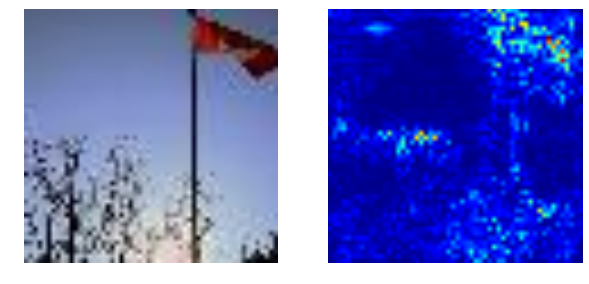

Actual label: flagpole
Top 5 predictions:
['flagpole', 'crane', 'pole', 'maypole', 'water tower']




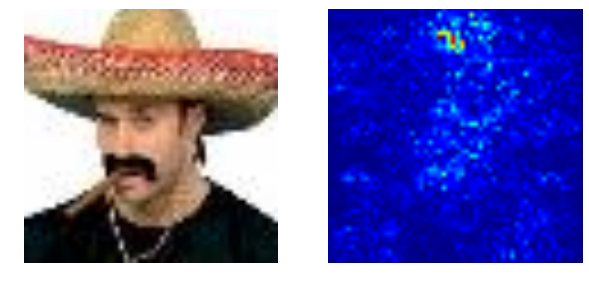

Actual label: sombrero
Top 5 predictions:
['sombrero', 'military uniform', 'umbrella', 'bow tie', 'sunglasses']




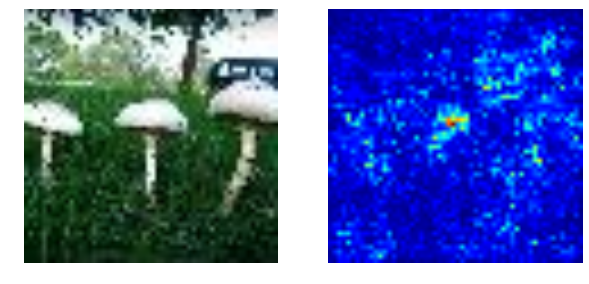

Actual label: mushroom
Top 5 predictions:
['mushroom', 'thatch', 'birdhouse', 'viaduct', 'gazelle']




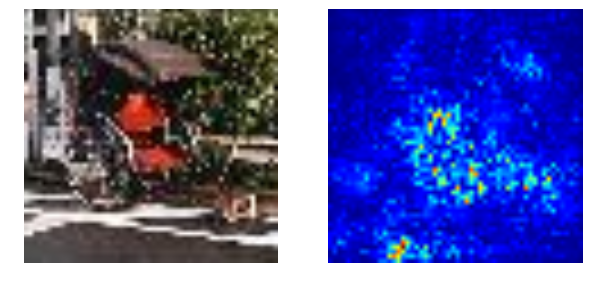

Actual label: jinrikisha
Top 5 predictions:
['jinrikisha', 'go-kart', 'lawn mower', 'tractor', 'umbrella']




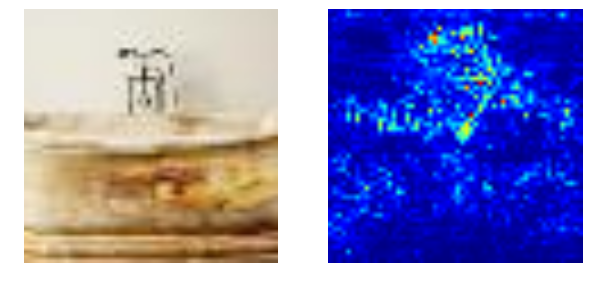

Actual label: bathtub
Top 5 predictions:
['nail', 'water tower', 'chest', 'beacon', 'rocking chair']




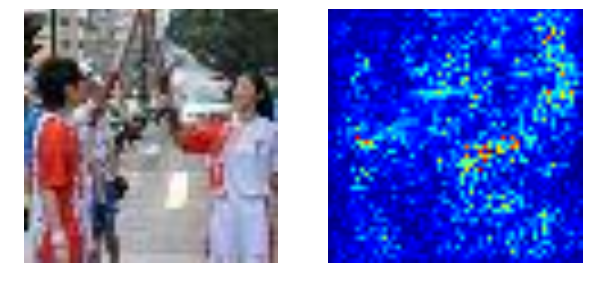

Actual label: torch
Top 5 predictions:
['torch', 'maypole', 'plunger', 'pole', 'jinrikisha']




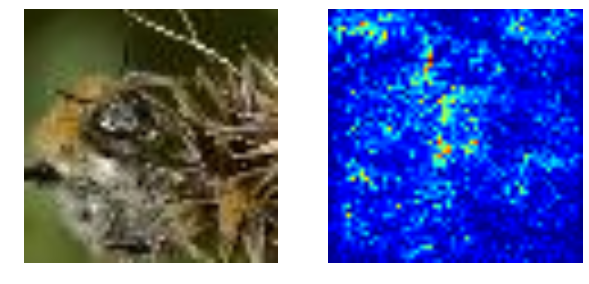

Actual label: bee
Top 5 predictions:
['bullfrog', 'boa constrictor', 'tailed frog', 'grasshopper', 'centipede']




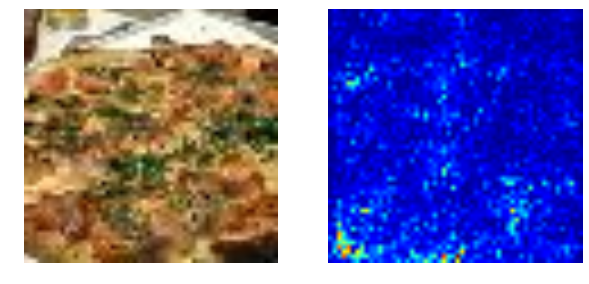

Actual label: pizza
Top 5 predictions:
['pizza', 'frying pan', 'wooden spoon', 'butcher shop', 'meat loaf']




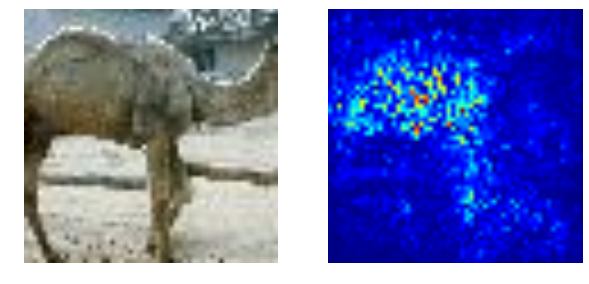

Actual label: Arabian camel
Top 5 predictions:
['Arabian camel', 'African elephant', 'bighorn', 'ox', 'lion']




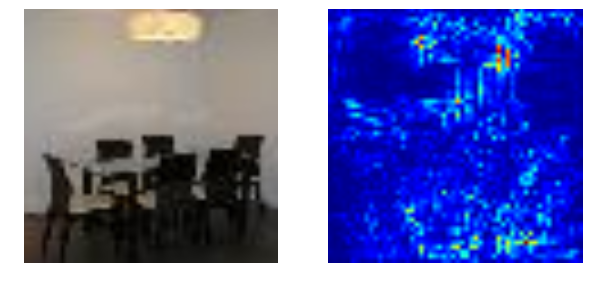

Actual label: dining table
Top 5 predictions:
['dining table', 'desk', 'computer keyboard', 'rocking chair', 'barbershop']




In [7]:
N = 10  # number of validation examples to view
filenames_labels = load_filenames_labels('val')
pick_N = random.sample(filenames_labels, N)
imgs = np.zeros((N, 64, 64, 3), dtype=np.uint8)
labels = []
for i, filename_label in enumerate(pick_N):
    imgs[i, :, :, :] = scipy.ndimage.imread(filename_label[0], mode='RGB')
    labels.append(class_description[int(filename_label[1])])
imgs = imgs[:, 4:60, 4:60, :]  # take center crop of images
config = TrainConfig()
top_5, sal_imgs = predict(imgs, config)
top_5 = top_5[1]  # 2nd element of list are class predictions
sal_imgs = sal_imgs[0]  # 1st element of list are saliency gradients
# root-sum-square RGB channels to generated saliency heat map
sal_imgs = np.sqrt(np.sum(np.square(sal_imgs), axis=3))

for idx, filename in enumerate(pick_N):
    plt.subplot(121)
    plt.imshow(imgs[idx, :, :, :])
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(sal_imgs[idx, :, :])
    plt.axis('off')
    plt.show()
    print('Actual label: ' + labels[idx])
    print('Top 5 predictions:')
    preds = map(lambda x: class_description[x], top_5[idx])
    print([x for x in preds])
    print('\n')
